<a href="https://colab.research.google.com/github/ykitaguchi77/CongenitalGlaucoma_AI_project/blob/main/DataSplit(stratified_one_subject_leave_out)2.1_Random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data_split for one-subject-leave-out stratified 5-fold crossvalidation**

In [ ]:
"""
Leave one subject out cross validation + 5-fold stratified cross validation

・1症例を抜き出し、その症例のすべての画像をテスト画像とする
・残りの症例の内斜視、外斜視、斜視なし群を、同じ症例が群をまたがないように5分割する。
・5分割したデータセットのうち4つをtraining、1つをvalidationとして用いてトレーニングを行い、抜き出した1症例のそれぞれの画像のおける正解率を算出する。これを5回繰り返してcross validationとする。

"""

In [2]:
import codecs
import pandas as pd
import os
import numpy as np
import shutil
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc
import pandas as pd
from PIL import Image
import tempfile
import time
import glob
import copy
import pickle
import itertools
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

random_seed = 1 #shuffleのシード



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_rows', 500)


gla_ortho_path = r"F:\先天性緑内障\dataset_for_article_250px\gla_ortho"
gla_eso_path = r"F:\先天性緑内障\dataset_for_article_250px\gla_eso"
gla_exo_path = r"F:\先天性緑内障\dataset_for_article_250px\gla_exo"
cont_ortho_path = r"F:\先天性緑内障\dataset_for_article_250px\cont_ortho"
cont_eso_path = r"F:\先天性緑内障\dataset_for_article_250px\cont_eso"
cont_exo_path = r"F:\先天性緑内障\dataset_for_article_250px\cont_exo"

result_csv_path = r"F:\先天性緑内障\result.csv"


"""
gla_ortho_path = r"F:\先天性緑内障\データ引継ぎ\children_d"
gla_eso_path = r"F:\先天性緑内障\データ引継ぎ\children_d__内斜視"
gla_exo_path = r"F:\先天性緑内障\データ引継ぎ\children_d__外斜視"
cont_ortho_path = r"F:\先天性緑内障\データ引継ぎ\children_control"
cont_eso_path = r"F:\先天性緑内障\データ引継ぎ\children_control__内斜視\内斜視かぶりなし"
cont_exo_path = r"F:\先天性緑内障\データ引継ぎ\children_control__外斜視\外斜視かぶりなし"
"""

def make_path_list(dir):
    path_list =  [file for file in glob.glob(dir+"/*") if os.path.isfile(file) == True ]
    return path_list

def extract_class(path_list, className):
    class_list = list(itertools.repeat(className,len(path_list)))
    return class_list

def extract_ids(path_list):
    id_list = [os.path.basename(name).split("_")[0] for name in path_list]
    return(id_list)


gla_ortho_path_list = make_path_list(gla_ortho_path)
gla_eso_path_list = make_path_list(gla_eso_path)
gla_exo_path_list = make_path_list(gla_exo_path)
cont_ortho_path_list = make_path_list(cont_ortho_path)
cont_eso_path_list = make_path_list(cont_eso_path)
cont_exo_path_list = make_path_list(cont_exo_path)

#それぞれの項目（path, classes, ID）をリスト化
gla_dataset_path = gla_ortho_path_list + gla_eso_path_list + gla_exo_path_list
gla_classes = extract_class(gla_ortho_path_list, "ortho") + extract_class(gla_eso_path_list, "eso") + extract_class(gla_exo_path_list, "exo")
gla_id = extract_ids(gla_ortho_path_list) + extract_ids(gla_eso_path_list) + extract_ids(gla_exo_path_list)
cont_dataset_path = cont_ortho_path_list + cont_eso_path_list + cont_exo_path_list
cont_classes = extract_class(cont_ortho_path_list, "ortho") + extract_class(cont_eso_path_list, "eso") + extract_class(cont_exo_path_list, "exo")
cont_id = extract_ids(cont_ortho_path_list) + extract_ids(cont_eso_path_list) + extract_ids(cont_exo_path_list)

#convert to Numpy(for use of Scikit-Learn)
gla_dataset_path = np.array(gla_dataset_path)
gla_classes = np.array(gla_classes)
gla_id = np.array(gla_id)
cont_dataset_path = np.array(cont_dataset_path)
cont_classes = np.array(cont_classes)
cont_id = np.array(cont_id)

print(len(gla_dataset_path))
print(len(cont_dataset_path))

204
612


In [ ]:

"""
------test_dataset[0]
  |
  |---train_dataset_gla[0]----0
  |                        |--1
  |                        |--2
  |                        |--3
  |                        |--4
  |---train_dataset_cont[0]----0
  |                         |--1
  |                         |--2
  |                         |--3
  |                         |--4
  |---val_dataset_gla[0]----0
  |                      |--1
  |                      |--2
  |                      |--3
  |                      |--4
  |---val_dataset_cont[0]----0
  |                       |--1
  |                       |--2
  |                       |--3
  |                       |--4
  |---test_dataset[1]
  ...

"""

'\n------test_dataset[0]\n  |\n  |---train_dataset_gla[0]----0\n  |                        |--1\n  |                        |--2\n  |                        |--3\n  |                        |--4\n  |---train_dataset_cont[0]----0\n  |                         |--1\n  |                         |--2\n  |                         |--3\n  |                         |--4\n  |---val_dataset_gla[0]----0\n  |                      |--1\n  |                      |--2\n  |                      |--3\n  |                      |--4\n  |---val_dataset_cont[0]----0\n  |                       |--1\n  |                       |--2\n  |                       |--3\n  |                       |--4\n  |---test_dataset[1]\n  ...\n\n'

In [3]:
train_dataset_gla, val_dataset_gla,train_dataset_cont, val_dataset_cont, testset, testset_label = [], [], [], [], [], []

#まずglaのデータセットから1人分を抜き出す（LeaveOneGroupOut)
# one group leave out 見本
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut
# 今回のケースでは、groupがIDに該当
logo = LeaveOneGroupOut()
logo.get_n_splits(gla_dataset_path, gla_classes, gla_id)
logo.get_n_splits(groups=gla_id)  # 'groups' is always required

k=0
for remain_index, test_index in logo.split(gla_dataset_path, gla_classes, gla_id):
    gla_dataset_path_remain, gla_dataset_path_test = gla_dataset_path[remain_index], gla_dataset_path[test_index]
    gla_classes_remain, gla_classes_test = gla_classes[remain_index], gla_classes[test_index]
    gla_id_remain, gla_id_test = gla_id[remain_index], gla_id[test_index]
    #print(gla_dataset_path, gla_dataset_path_test, gla_id_train, gla_id_test)
    #print("test: "+gla_id_test[0])
    #print("TRAIN:", remain_index, "TEST:", test_index)
    #print(gla_dataset_path_test[0])
    testset.append(gla_dataset_path_test.tolist())
    testset_label.append(list(itertools.repeat(1, len(gla_dataset_path_test))))

    #抜き出した残りのglaについてStratified group 5-foldをかける
    # example of stratified group Kfold　見本
    # 今回のケースでは、groupがID、yがclassesに該当

    cv = StratifiedGroupKFold(n_splits=5, shuffle = True, random_state = random_seed)
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(gla_dataset_path_remain, gla_classes_remain, gla_id_remain):
        #print("TRAIN:", gla_classes_remain[train_idxs])
        #print("      ", gla_id_remain[train_idxs])
        #print("      ", gla_dataset_path_remain[train_idxs])
        #print(" TEST:", gla_classes_remain[val_idxs])
        #print("      ", gla_id_remain[val_idxs])
        #print("      ", gla_dataset_path_remain[val_idxs])
        train_miniset[m] = gla_dataset_path_remain[train_idxs].tolist()
        val_miniset[m] = gla_dataset_path_remain[val_idxs].tolist()
        m+=1
    train_dataset_gla.append(train_miniset)
    val_dataset_gla.append(val_miniset)
    #print("train_dataset_added label[gla] " + str(k))
    k+=1

    #control全体についてStratified group 5-foldをかける
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(cont_dataset_path, cont_classes, cont_id):
        #print("TRAIN:", cont_classes[train_idxs])
        #print("      ", cont_id[train_idxs])
        #print("      ", cont_dataset_path[train_idxs])
        #print(" TEST:", cont_classes[val_idxs])
        #print("      ", cont_id[val_idxs])
        #print("      ", cont_dataset_path[val_idxs])
        train_miniset[m] = cont_dataset_path[train_idxs].tolist()
        val_miniset[m] = cont_dataset_path[val_idxs].tolist()
        m+=1
    train_dataset_cont.append(train_miniset)
    val_dataset_cont.append(val_miniset)

        
#print(len(train_dataset_gla))    
#print(len(val_dataset_gla))
#print(val_dataset_gla)
#print(len(train_dataset_cont))    
#print(len(val_dataset_cont))
#print(len(test_dataset))


#同じくcontのデータセットから1人分抜き出してLeaveOneGroupOutをする
logo = LeaveOneGroupOut()
logo.get_n_splits(cont_dataset_path, cont_classes, cont_id)
logo.get_n_splits(groups=cont_id)  # 'groups' is always required

k=0
for remain_index, test_index in logo.split(cont_dataset_path, cont_classes, cont_id):
    cont_dataset_path_remain, cont_dataset_path_test = cont_dataset_path[remain_index], cont_dataset_path[test_index]
    cont_classes_remain, cont_classes_test = cont_classes[remain_index], cont_classes[test_index]
    cont_id_remain, cont_id_test = cont_id[remain_index], cont_id[test_index]
    #print(cont_dataset_path_test[0])
    testset.append(cont_dataset_path_test.tolist())
    testset_label.append(list(itertools.repeat(0, len(cont_dataset_path_test))))

    #抜き出した残りのcontについてStratified group 5-foldをかける

    cv = StratifiedGroupKFold(n_splits=5, shuffle = True, random_state = random_seed)
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(cont_dataset_path_remain, cont_classes_remain, cont_id_remain):
        train_miniset[m] = cont_dataset_path_remain[train_idxs].tolist()
        val_miniset[m] = cont_dataset_path_remain[val_idxs].tolist()
        m+=1
    train_dataset_cont.append(train_miniset)
    val_dataset_cont.append(val_miniset)

    #gla全体についてStratified group 5-foldをかける
    m=0 
    train_miniset, val_miniset =  [0 for i in range(0, 5)], [0 for i in range(0, 5)]
    for train_idxs, val_idxs in cv.split(gla_dataset_path, gla_classes, gla_id):
        train_miniset[m] = gla_dataset_path[train_idxs].tolist()
        val_miniset[m] = gla_dataset_path[val_idxs].tolist()
        m+=1
    train_dataset_gla.append(train_miniset)
    val_dataset_gla.append(val_miniset)
    #print("train_dataset_added label[cont] "+ str(k))
    k+=1
        
print(len(train_dataset_gla))    
print(len(val_dataset_gla))
print(len(train_dataset_cont))    
print(len(val_dataset_cont))
print(len(testset))
print(len(testset_label))


641
641
641
641
641
641


#**Modules**

In [4]:
PX = 224 #画像のサイズ
TRAIN_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]
TRAIN_CROP_SCALE =(0.9,1.0)
#TRAIN_BRIGHTNESS_PARAM = 0.2
#TRAIN_CONTRAST_PARAM = 0.1
#TRAIN_SATURATION_PARAM = 0.1
TRAIN_RANDOM_ROTATION = 3
TRAIN_HUE_PARAM = 0.02
VAL_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]

class Expand2square(object):
    """
    長方形の元画像を長辺を1辺とする正方形に貼り付け、空白を黒く塗りつぶす
    """
    def __init__(self, background_color):
        self.background_color = background_color

    def __call__(self, pil_img):
        width, height = pil_img.size
        if width == height:
            return pil_img
        elif width > height:
            result = Image.new(pil_img.mode, (width, width), self.background_color)
            result.paste(pil_img, (0, (width-height)//2))
            return result
        else:
            result = Image.new(pil_img.mode, (height, height), self.background_color)
            result.paste(pil_img, (0, (height - width) // 2))
            return result

class SimpleImageDataset(Dataset):
    def __init__(self, img_list, label_list, transform):
        self.transform = transform
        self.img_list = img_list
        self.label_list = label_list
        self.item_dict = {}
        self.age = []
        #print(img_list)
        #print(label_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path = self.img_list[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor(self.label_list[idx])      
        return tensor_image, target

#画像読み込み時間削減のため、Expand2squareの処理は行っている
train_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])




#少数の画像を可視化
def imshow(inp, title=None):
    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




#Defining early stopping class

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


#Train models
def train_model(model, criterion, optimizer, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    torch.backends.cudnn.benchmark = True

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print('-' * 10)

        ###################
        # train the model #
        ###################
        model.train() # Set model to training mode
        
        running_corrects, train_acc= 0, 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            
            # Runs the forward pass with autocasting.
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()

            """
            # forward
            # track history if only in train
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()
            """

            # record training loss
            train_losses.append(loss.item())

            running_corrects += torch.sum(preds==labels)

            """
            print("preds:"+str(preds))
            print("labels:"+str(labels))
            print("running_corrects: "+str(str(running_corrects)))
            """
        #print()   
        train_acc = running_corrects.item()/len(train_dataset)

        #####################
        # validate the model#
        #####################

        model.eval()   # Set model to evaluate mode

        running_corrects, val_acc= 0, 0

        # Iterate over data.
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
           
            """
            print("preds:"+str(preds))
            print("labels:"+str(labels))
            print("running_corrects: "+str(str(running_corrects)))
            """

            valid_losses.append(loss.item())

            running_corrects += torch.sum(preds==labels)
        val_acc = running_corrects.item()/len(val_dataset)



        #####################
        # test the model#
        #####################

        model.eval()   # Set model to evaluate mode

        running_corrects, test_acc= 0, 0

        # Iterate over data.
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
            
            """
            print("preds:"+str(preds))
            print("labels:"+str(labels))
            print("running_corrects: "+str(str(running_corrects)))
            """

            running_corrects += torch.sum(preds==labels)
        test_acc = running_corrects.item()/len(test_dataset)



        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(num_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +
                     f'train_acc: {train_acc:.5f}' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'valid_acc: {val_acc:.5f}' +'\n'
                     f'test_acc: {test_acc:.5f}' + f'({running_corrects:.0f}/{len(test_dataset):.0f})') 

        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses



#Visualize model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)




def Draw_roc_curve(label_list_list, model_pred_prob_list, sample_num_list, num_curves,class_names):

#グラフの外形を作成
    fig = plt.figure(figsize=(8.0, 6.0))
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ycolor = ["r", "g", "b", "c", "m", "y", "k", "w"]      # 各プロットの色
    plt.legend(loc="lower right")

    k=0
    for j in range(num_curves):
        y_score = []
        y_true = []

        for i in label_list_list[k]:
            if i == class_names[0]:
                  y_true.append(0)
            elif i == class_names[1]:
                  y_true.append(1)
            
        #それぞれの画像における陽性の確率についてリストを作成
        y_score = model_pred_prob_list[k]

        fpr, tpr,thred = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=ycolor[k],lw=lw, label= str(roc_label_list[k])+':ROC curve (area = %0.2f)' % roc_auc)
            
        k+=1

    plt.legend(loc="lower right")
    plt.show()
    return fig

def calculate_auc(label_list, model_pred_prob, class_names):
    y_true, y_score = [], []
    for i in label_list:
        if i == class_names[0]:
              y_true.append(0)
        elif i == class_names[1]:
              y_true.append(1)
            
    #それぞれの画像における陽性の確率についてリストを作成
    y_score = model_pred_prob

    print(y_true)
    print(len(y_true))
    print(y_score)
    print(len(y_score))

    fpr, tpr,thred = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    print("roc_auc: " +str(roc_auc))
    return(roc_auc, y_true, y_score)

#**Define RepVGG**

In [5]:
import requests

def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model



#RepVGGのpretrained modelをダウンロード
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1PvtYTOX4gd-1VHX8LoT7s6KIyfTKOf8G'
destination = "F:\先天性緑内障\RepVGG-A2.pth"

if os.path.exists(destination) is not True:
    download_file_from_google_drive(file_id, destination)
else:
    print("pretrained repVGG model already exists")


pretrained repVGG model already exists


#**Deploy RepVGG_A2**

In [6]:
#deploy RepVGG-A2
"""
train_model = create_RepVGG_A2(deploy=False)
train_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/RepVGG-A2-train.pth'))   
model_ft = repvgg_model_convert(train_model, create_RepVGG_A2, save_path='/content/drive/MyDrive/Deep_learning/repvgg-A2-deploy.pth')
"""
model_ft = create_RepVGG_A2(deploy=False)

#use pretrained model
#model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/RepVGG-A2-train.pth'))   
model_ft.load_state_dict(torch.load ("F:\先天性緑内障\RepVGG-A2.pth"))   
num_ftrs = model_ft.linear.in_features
model_ft.linear = nn.Linear(num_ftrs, 2)


#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#https://blog.knjcode.com/adabound-memo/
#https://pypi.org/project/torch-optimizer/
from ranger_adabelief import RangerAdaBelief
optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identit

#**Dataset and Dataloader**

In [ ]:
pt=5
fold=0
train_list = train_dataset_gla[pt][fold] + train_dataset_cont[pt][fold]
train_list_label = list(itertools.repeat(1, len(train_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(train_dataset_cont[pt][fold])))
val_list = val_dataset_gla[pt][fold] + val_dataset_cont[pt][fold]
val_list_label = list(itertools.repeat(1, len(val_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(val_dataset_cont[pt][fold])))
test_list = testset[pt]
test_list_label = testset_label[pt]

print(len(train_list))
print(len(val_list))
print(len(test_list))

#データセットの確認
for i, j in zip(test_list, test_list_label):
    print(i,j)

669
166
2
F:\先天性緑内障\dataset_for_article_250px\gla_ortho\3422_1.jpg 1
F:\先天性緑内障\dataset_for_article_250px\gla_ortho\3422_2.jpg 1


In [ ]:
train_list = []
train_list_label = []
val_list = []
val_list_label = []
test_list = []
test_list_label = []

"""
#早川さんのデータセット
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\data9卒論用\train\dise\*"):
    train_list.append(img_path)
    train_list_label.append(1)
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\data9卒論用__square\train\cont\*"):
    train_list.append(img_path)
    train_list_label.append(0)
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\data9卒論用__square\val\dise\*"):
    val_list.append(img_path)
    val_list_label.append(1)
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\data9卒論用__square\val\cont\*"):
    val_list.append(img_path)
    val_list_label.append(0)
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\data9卒論用__square\test\dise\*"):
    test_list.append(img_path)
    test_list_label.append(1)
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\data9卒論用__square\test\cont\*"):
    test_list.append(img_path)
    test_list_label.append(0)

"""
#Stratified dataset folder
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\Stratified\train\gla\*"):
    train_list.append(img_path)
    train_list_label.append(1)
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\Stratified\train\cont\*"):
    train_list.append(img_path)
    train_list_label.append(0)
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\Stratified\val\gla\*"):
    val_list.append(img_path)
    val_list_label.append(1)
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\Stratified\val\cont\*"):
    val_list.append(img_path)
    val_list_label.append(0)
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\data9卒論用__square\test\dise\*"):
    test_list.append(img_path)
    test_list_label.append(1)
for img_path in glob.glob(r"F:\先天性緑内障\データ引継ぎ\data9卒論用__square\test\cont\*"):
    test_list.append(img_path)
    test_list_label.append(0)


train_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

print(len(train_list))
print(len(val_list))
print(len(test_list))

#データセットの確認
for i, j in zip(train_list, train_list_label):
    print(i,j)

tensor([1])


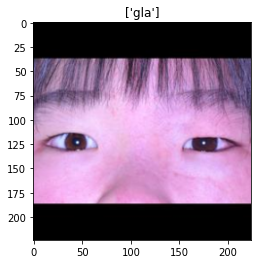

In [ ]:
train_dataset = SimpleImageDataset(train_list, train_list_label, train_data_transforms)
val_dataset = SimpleImageDataset(val_list, val_list_label, val_data_transforms)
test_dataset = SimpleImageDataset(test_list, test_list_label, test_data_transforms)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

# Make a grid from batch
inputs, classes = next(iter(test_loader))
print(classes)
out = torchvision.utils.make_grid(inputs)

class_names = ["cont", "gla"]
imshow(out, title=[class_names[x] for x in classes])

#**Training and evaluation**

In [ ]:
#model_ft = torchvision.models.resnet50(pretrained=True)  
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = create_RepVGG_A2(deploy=False)
model_ft.load_state_dict(torch.load ("F:\先天性緑内障\RepVGG-A2.pth"))   
num_ftrs = model_ft.linear.in_features
model_ft.linear = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#https://blog.knjcode.com/adabound-memo/
#https://pypi.org/project/torch-optimizer/
from ranger_adabelief import RangerAdaBelief
optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=30, num_epochs=150)

In [ ]:
model_ft.eval() # prep model for evaluation

targets, preds =[], []
for image_tensor, target in test_loader:  
      #target = target.squeeze(1)     
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)
      _, pred = torch.max(output, 1)  
      preds.append(int(pred))  #予測結果
      targets.append(int(target)) #ラベル

y_test = np.array(targets)
y_pred = np.array(preds)
print(y_test)
print(y_pred)

In [ ]:
#保存用の空CSVを作成
pt_num = []
k=0
for data in testset:
    pt_num.append([k]*len(data))
    k+=1

img_num = []
for data in testset:
    img_num.append(list(range(len(data))))

patient_num = list(itertools.chain.from_iterable(pt_num))
img_num = list(itertools.chain.from_iterable(img_num))
patient_path = list(itertools.chain.from_iterable(testset))
patient_label = list(itertools.chain.from_iterable(testset_label))

df_result = pd.DataFrame(index=[],columns=[])
df_result = pd.DataFrame(index=[],columns=["pt_number","img_number", "path","label", "0","1","2","3","4", "prob_1", "prob_2", "prob_3", "prob_4", "prob_5"])
df_result["pt_number"] = patient_num
df_result["img_number"] = img_num
df_result["path"] = patient_path
df_result["label"] = patient_label
df_result



In [ ]:
#Write results in CSV 
pt=1
fold = 1

row = 0
for i in testset[0:pt]:
    row += len(i)
column = fold + 4


print(row, column)
df_result.iloc[row:row+len(y_pred), column] = y_pred

7 5


#**Automated analysis**

In [ ]:
#保存用の空CSVを作成
pt_num = []
k=0
for data in testset:
    pt_num.append([k]*len(data))
    k+=1

img_num = []
for data in testset:
    img_num.append(list(range(len(data))))

patient_num = list(itertools.chain.from_iterable(pt_num))
img_num = list(itertools.chain.from_iterable(img_num))
patient_path = list(itertools.chain.from_iterable(testset))
patient_label = list(itertools.chain.from_iterable(testset_label))

df_result = pd.DataFrame(index=[],columns=[])
df_result = pd.DataFrame(index=[],columns=["pt_number","img_number", "path","label", "0","1","2","3","4", "prob_1", "prob_2", "prob_3", "prob_4", "prob_5"])
df_result["pt_number"] = patient_num
df_result["img_number"] = img_num
df_result["path"] = patient_path
df_result["label"] = patient_label

df_result.to_csv(r"F:\先天性緑内障\result.csv",encoding="shift_jis", index=False)
df_result

In [ ]:
df_result.to_csv(result_csv_path,encoding="shift_jis", index=False) #save as csv

patient: 368, fold: 0
656
159
1
tensor([0])


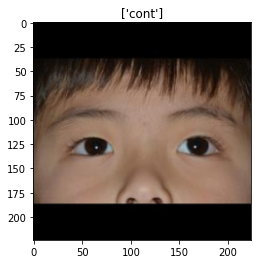

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identit

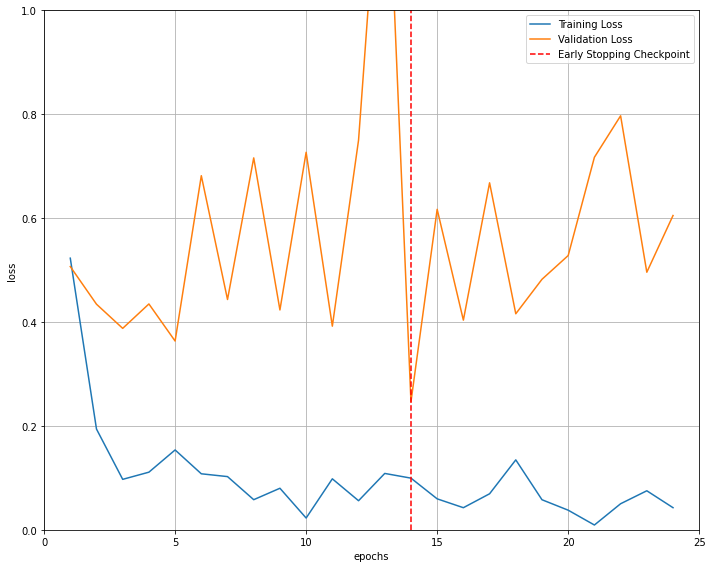

tensor(0.0042)
tensor([0], device='cuda:0')
label
[0]
pred
[0]
prob
[0.00423304]


NameError: ignored

In [7]:
#Open reslut_csv
with codecs.open(result_csv_path, "r", "Shift-JIS", "ignore") as file:
        df_result = pd.read_csv(file, index_col=None, header=0)

time_start = time.perf_counter()

#pt,foldの初期値を入力（CSVに対応）
pt=368
fold=0

for pt in range(pt,len(testset)): #指定したPtから開始
    for fold in list(range(5)):
        print("patient: "+str(pt)+", fold: "+str(fold))

        train_list = train_dataset_gla[pt][fold] + train_dataset_cont[pt][fold]
        train_list_label = list(itertools.repeat(1, len(train_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(train_dataset_cont[pt][fold])))
        val_list = val_dataset_gla[pt][fold] + val_dataset_cont[pt][fold]
        val_list_label = list(itertools.repeat(1, len(val_dataset_gla[pt][fold])))+list(itertools.repeat(0, len(val_dataset_cont[pt][fold])))
        test_list = testset[pt]
        test_list_label = testset_label[pt]

        print(len(train_list))
        print(len(val_list))
        print(len(test_list))


        #define dataset and dataloader
        train_dataset = SimpleImageDataset(train_list, train_list_label, train_data_transforms)
        val_dataset = SimpleImageDataset(val_list, val_list_label, val_data_transforms)
        test_dataset = SimpleImageDataset(test_list, test_list_label, test_data_transforms)

        train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

        # show sample image
        inputs, classes = next(iter(test_loader))
        print(classes)
        out = torchvision.utils.make_grid(inputs)
        class_names = ["cont", "gla"]
        imshow(out, title=[class_names[x] for x in classes])


        model_ft = create_RepVGG_A2(deploy=False)
        model_ft.load_state_dict(torch.load ("F:\先天性緑内障\RepVGG-A2.pth"))   
        num_ftrs = model_ft.linear.in_features
        model_ft.linear = nn.Linear(num_ftrs, 2)

        #GPU使用
        model_ft = model_ft.to(device)

        #損失関数を定義
        criterion = nn.CrossEntropyLoss()

        # Observe that all parameters are being optimized
        #https://blog.knjcode.com/adabound-memo/
        #https://pypi.org/project/torch-optimizer/
        from ranger_adabelief import RangerAdaBelief
        optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999))

        model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=10, num_epochs=30)


        # visualize the loss as the network trained
        fig = plt.figure(figsize=(10,8))
        plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
        plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

        # find position of lowest validation loss
        minposs = valid_loss.index(min(valid_loss))+1 
        plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.ylim(0, 1.0) # consistent scale
        plt.xlim(0, len(train_loss)+1) # consistent scale
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        fig.savefig('loss_plot.png', bbox_inches='tight')

        #Prediction for testset
        model_ft.eval() # prep model for evaluation
        targets, probs, preds =[], [], []
        for image_tensor, target in test_loader:  
              #target = target.squeeze(1)     
              image_tensor = image_tensor.to(device)
              target = target.to(device)
              # forward pass: compute predicted outputs by passing inputs to the model
              output = model_ft(image_tensor)
              _, pred = torch.max(output, 1) 
            
              prob = nn.Softmax(dim=1)(output) #calculate probalility
              prob = prob[0][1].cpu().detach() #probalility of being positive
              print(prob)
              print(pred) 
              
              probs.append(prob)
              preds.append(int(pred))  #予測結果
              targets.append(int(target)) #ラベル
        y_test = np.array(targets)
        y_pred = np.array(preds)
        y_prob = np.array(probs)
        print("label")
        print(y_test)
        print("pred")
        print(y_pred)
        print("prob")
        print(y_prob)

        #write result to df
        row = 0
        for i in testset[0:pt]:
            row += len(i)
        column = fold + 4
        df_result.iloc[row:row+len(y_pred), column] = y_pred
        column = fold + 9
        df_result.iloc[row:row+len(y_pred), column] = y_prob
        df_result.to_csv(result_csv_path,encoding="shift_jis", index=False) #save as csv
        

        #経過時間を表示
        time_end = time.perf_counter()
        time_elapsed = (time_end - time_start)
        print("Elapsed time: "+str(time_elapsed))



#**データセットをフォルダにコピー**

In [ ]:
#データのパスを指定
pt=0
fold=0
train_list_gla = train_dataset_gla[pt][fold] 
train_list_cont = train_dataset_cont[pt][fold]
val_list_gla = val_dataset_gla[pt][fold]
val_list_cont = val_dataset_cont[pt][fold]

#パスを指定
train_gla = r"F:\先天性緑内障\データ引継ぎ\stratified\train\gla"
train_cont = r"F:\先天性緑内障\データ引継ぎ\stratified\train\cont"
val_gla = r"F:\先天性緑内障\データ引継ぎ\stratified\val\gla"
val_cont = r"F:\先天性緑内障\データ引継ぎ\stratified\val\cont"

orig_path = [train_list_gla, train_list_cont, val_list_gla, val_list_cont]
dst_path = [train_gla, train_cont, val_gla, val_cont]


for folder in dst_path:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder, exist_ok=True) 

for i in orig_path:
    print(len(i))


for orig_img_list, dst_folder in zip(orig_path, dst_path):
    if not orig_img_list:
        pass
    else:
        for origpath in orig_img_list:
            basepath = os.path.basename(origpath)
            dstpath = os.path.join(dst_folder, basepath)
            shutil.copyfile(origpath, dstpath)
            print(dstpath+ " copied!")

In [ ]:
df_result

,pt_number,img_number,path,label,0,1,2,3,4,prob_1,prob_2,prob_3,prob_4,prob_5
0,0,0,F:\先天性緑内障\dataset_for_article_250px\gla_ortho\...,1,0,0,0,0,0,0.140565,0.022391,0.021274,0.004684,0.205459
1,0,1,F:\先天性緑内障\dataset_for_article_250px\gla_ortho\...,1,0,0,0,0,0,0.218823,0.006911,0.032282,0.002136,0.020692
2,0,2,F:\先天性緑内障\dataset_for_article_250px\gla_ortho\...,1,0,0,0,0,0,0.344512,0.062691,0.10466,0.020558,0.194618
3,0,3,F:\先天性緑内障\dataset_for_article_250px\gla_ortho\...,1,0,0,0,0,0,0.310884,0.040014,0.06282,0.011039,0.034052
4,0,4,F:\先天性緑内障\dataset_for_article_250px\gla_exo\15...,1,0,0,0,0,0,0.167769,0.174175,0.038809,0.002429,0.288133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,655,0,F:\先天性緑内障\dataset_for_article_250px\cont_ortho...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
833,656,0,F:\先天性緑内障\dataset_for_article_250px\cont_ortho...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,657,0,F:\先天性緑内障\dataset_for_article_250px\cont_eso\9...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,658,0,F:\先天性緑内障\dataset_for_article_250px\cont_exo\9...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#**結果のCSVを開く**

In [ ]:
with codecs.open(result_csv_path, "r", "Shift-JIS", "ignore") as file:
        df_result = pd.read_csv(file, index_col=None, header=0)
df_result

,pt_number,img_number,path,label,0,1,2,3,4,prob_1,prob_2,prob_3,prob_4,prob_5
0,0,0,F:\先天性緑内障\dataset_for_article_250px\gla_ortho\...,1,0,0,0,0,0,0.000348,0.000086,0.008044,0.000562,3.919517e-07
1,0,1,F:\先天性緑内障\dataset_for_article_250px\gla_ortho\...,1,0,0,0,0,1,0.049972,0.003216,0.001366,0.010509,7.691265e-01
2,0,2,F:\先天性緑内障\dataset_for_article_250px\gla_ortho\...,1,0,0,0,0,1,0.031830,0.012071,0.059857,0.100573,6.572282e-01
3,0,3,F:\先天性緑内障\dataset_for_article_250px\gla_ortho\...,1,1,1,0,0,1,0.510193,0.816240,0.073786,0.033326,9.986442e-01
4,0,4,F:\先天性緑内障\dataset_for_article_250px\gla_exo\15...,1,0,0,0,0,0,0.119077,0.000229,0.001036,0.002353,1.773554e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,655,0,F:\先天性緑内障\dataset_for_article_250px\cont_ortho...,0,0,0,0,0,0,0.409229,0.058354,0.021793,0.089104,8.373380e-03
833,656,0,F:\先天性緑内障\dataset_for_article_250px\cont_ortho...,0,0,0,0,0,0,0.000019,0.000175,0.007191,0.000092,7.552663e-05
834,657,0,F:\先天性緑内障\dataset_for_article_250px\cont_eso\9...,0,0,0,0,0,0,0.004513,0.000074,0.039156,0.009142,7.524125e-02
835,658,0,F:\先天性緑内障\dataset_for_article_250px\cont_exo\9...,0,0,0,0,0,0,0.000851,0.000012,0.000002,0.000007,1.587212e-02


In [ ]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import sklearn; 


#sorted(sklearn.metrics.SCORERS.keys())


#indexの内容を確認
#print(df.columns.values.tolist())


FEATURE_COLS=df_result.columns.values[1:].tolist()

"""
FEATURE_COLS=[
 'cropped_A2',
 'cropped_B3']
"""

print(FEATURE_COLS)

# 訓練データとテストデータに分割する。
from sklearn.model_selection import train_test_split
# TODO:層別サンプリング train, test = train_test_split(df, test_size=0.20, stratify=df["町区分"], random_state=100)
train, test = train_test_split(df_result, test_size=0.20,random_state=100)

X_train = train[FEATURE_COLS[8:13]]
Y_train = train["label"]
X_test = test[FEATURE_COLS[8:13]]
Y_test = test["label"]


['img_number', 'path', 'label', '0', '1', '2', '3', '4', 'prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5']


In [ ]:
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import sklearn; 

!pip install bayesian-optimization 
from bayes_opt import BayesianOptimization


#　　精度確認
# 自由度調整済みr2を算出
def adjusted_r2(X,Y):
    from sklearn.metrics import r2_score
    import numpy as np
    r_squared = r2_score(Y, X)
    adjusted_r2 = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-2)
    #yhat = model.predict(X) \ #SS_Residual = sum((Y-yhat)**2) \ #SS_Total = sum((Y-np.mean(Y))**2)
    #r_squared = 1 - (float(SS_Residual))/ SS_Total
    return adjusted_r2

# 予測モデルの精度確認の各種指標を算出
def get_model_evaluations(X_train,Y_train,X_test,Y_test):
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import median_absolute_error

   # 評価指標確認
   # 参考: https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/
    yhat_test = X_test

    print("adjusted_r2(train)     :" + str(adjusted_r2(X_train,Y_train)))
    print("adjusted_r2(test)      :" + str(adjusted_r2(X_test,Y_test)))   
    #print("平均誤差率(test)       :" + str(np.mean(abs(Y_test / yhat_test - 1)))) 
    print("MAE(test)              :" + str(mean_absolute_error(Y_test, yhat_test)))
    print("MedianAE(test)         :" + str(median_absolute_error(Y_test, yhat_test)))
    print("RMSE(test)             :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test))))
    print("RMSE(test) / MAE(test) :" + str(np.sqrt(mean_squared_error(Y_test, yhat_test)) / mean_absolute_error(Y_test, yhat_test))) #better if result = 1.253





for i in FEATURE_COLS[8:13]:
    X_train = train[i]
    Y_train = train["label"]
    X_test = test[i]
    Y_test = test["label"]
    print(str(i))
    get_model_evaluations(X_train,Y_train,X_test,Y_test)
    print("")






#後の解析のためにそれぞれの項目を戻しておく
X_train = train[FEATURE_COLS[8:13]]
Y_train = train["label"]
X_test = test[FEATURE_COLS[8:13]]
Y_test = test["label"]


Accuracy: 0.8869047619047619
26 11 8 123
confusion matrix = 
 [[123   8]
 [ 11  26]]
Accuracy : 0.8869047619047619
Precision (true positive rate) : 0.7647058823529411
Recall (sensitivity): 0.7027027027027027
Specificity : 0.9389312977099237
F1 score : 0.7323943661971832
Area_under_ROC : 0.9107695481741283


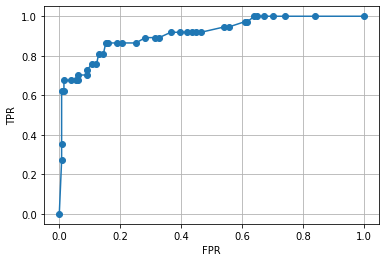

In [ ]:
import xgboost as xgb

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score


"""XGBoost で二値分類するサンプルコード"""

X_train = train[FEATURE_COLS[8:13]]
Y_train = train["label"]
X_test = test[FEATURE_COLS[8:13]]
Y_test = test["label"]


# XGBoost が扱うデータセットの形式に直す
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)
# 学習用のパラメータ
xgb_params = {
    # 二値分類問題
    'objective': 'binary:logistic',
    # 評価指標
    'eval_metric': 'logloss',
}
# モデルを学習する
bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=100,  # 学習ラウンド数は適当
                )
# 検証用データが各クラスに分類される確率を計算する
Y_pred_proba = bst.predict(dtest)
# しきい値 0.5 で 0, 1 に丸める
Y_pred = np.where(Y_pred_proba > 0.5, 1, 0)
# 精度 (Accuracy) を検証する
acc = accuracy_score(Y_test, Y_pred)
print('Accuracy:', acc)


tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print(tp, fn, fp, tn)

def specificity_score(label, pred):
    tn, fp, fn, tp = confusion_matrix(label, pred).flatten()
    return tn / (tn + fp)


print('confusion matrix = \n', confusion_matrix(Y_test, Y_pred))
print(f'Accuracy : {accuracy_score(Y_test, Y_pred)}')
print(f'Precision (true positive rate) : {precision_score(Y_test, Y_pred)}')
print(f'Recall (sensitivity): {recall_score(Y_test, Y_pred)}')
print(f'Specificity : {specificity_score(Y_test, Y_pred)}')
print(f'F1 score : {f1_score(Y_test, Y_pred)}')


#ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)     
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
print(f'Area_under_ROC : {roc_auc_score(Y_test, Y_pred_proba)}')
#plt.savefig('plots/roc_curve.png')


fold 8
Accuracy: 0.9091995221027479
145 59 17 616
confusion matrix = 
 [[616  17]
 [ 59 145]]
Accuracy : 0.9091995221027479
Precision (true positive rate) : 0.8950617283950617
Recall (sensitivity): 0.7107843137254902
Specificity : 0.9731437598736177
F1 score : 0.7923497267759562
Area_under_ROC : 0.9188504785800576

fold 9
Accuracy: 0.9080047789725209
139 65 12 621
confusion matrix = 
 [[621  12]
 [ 65 139]]
Accuracy : 0.9080047789725209
Precision (true positive rate) : 0.9205298013245033
Recall (sensitivity): 0.6813725490196079
Specificity : 0.981042654028436
F1 score : 0.7830985915492958
Area_under_ROC : 0.9277096304556578

fold 10
Accuracy: 0.8387096774193549
100 104 31 602
confusion matrix = 
 [[602  31]
 [104 100]]
Accuracy : 0.8387096774193549
Precision (true positive rate) : 0.7633587786259542
Recall (sensitivity): 0.49019607843137253
Specificity : 0.9510268562401264
F1 score : 0.5970149253731344
Area_under_ROC : 0.8440123284700927

fold 11
Accuracy: 0.8375149342891278
101 103 33

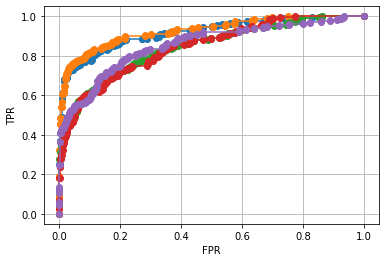

In [ ]:
import statistics

accuracy = []
precision = []
recall = []
specificity = []
f1score = []
area_u_ROC = []

for i in range(8,13):
    print("fold",i)
    X = df_result[FEATURE_COLS[i]]
    Y = df_result["label"]

    Y_pred_proba = X
    Y_pred = np.where(Y_pred_proba >= 0.5, 1, 0)

    acc = accuracy_score(Y, Y_pred)
    print('Accuracy:',acc)

    tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
    print(tp, fn, fp, tn)

    def specificity_score(label, pred):
        tn, fp, fn, tp = confusion_matrix(label, pred).flatten()
        return tn / (tn + fp)


    print('confusion matrix = \n', confusion_matrix(Y, Y_pred))
    print(f'Accuracy : {accuracy_score(Y, Y_pred)}')
    print(f'Precision (true positive rate) : {precision_score(Y, Y_pred)}')
    print(f'Recall (sensitivity): {recall_score(Y, Y_pred)}')
    print(f'Specificity : {specificity_score(Y, Y_pred)}')
    print(f'F1 score : {f1_score(Y, Y_pred)}')

    #ROC curve
    fpr, tpr, thresholds = roc_curve(Y, Y_pred_proba)     
    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    print(f'Area_under_ROC : {roc_auc_score(Y, Y_pred_proba)}')
    #plt.savefig('plots/roc_curve.png')

    accuracy.append(accuracy_score(Y, Y_pred))
    precision.append(precision_score(Y, Y_pred))
    recall.append(recall_score(Y, Y_pred))
    specificity.append(specificity_score(Y, Y_pred))
    f1score.append(f1_score(Y, Y_pred))
    area_u_ROC.append(roc_auc_score(Y, Y_pred_proba))

    print("")

print("Result of 5-fold crossvalidation")
print("accuracy: ", statistics.mean(accuracy))
print("precision: ", statistics.mean(precision))
print("recall (sensitivity): ", statistics.mean(recall))
print("specifiity: ", statistics.mean(specificity))
print("f1_score: ", statistics.mean(f1score))
print("area_u_ROC: ", statistics.mean(area_u_ROC))

|  74       | -0.3356   |  1.0      |  0.5      |  0.3      |  8.0      |  1.0      |  1.251e+0 |  28.68    |  1e-05    |  0.6      |
|  75       | -0.3122   |  0.8415   |  0.3932   |  0.2357   |  4.462    |  1.995    |  1.612e+0 |  31.23    |  0.4654   |  0.8924   |
|  76       | -0.2992   |  0.6949   |  0.08948  |  0.144    |  3.113    |  2.259    |  1.839e+0 |  30.86    |  0.7651   |  0.9233   |
|  77       | -0.2739   |  0.8555   |  0.3775   |  0.1969   |  3.244    |  1.095    |  1.146e+0 |  15.52    |  0.3417   |  0.7824   |
|  78       | -0.2702   |  0.6231   |  0.3908   |  0.1312   |  5.732    |  1.568    |  1.429e+0 |  0.4269   |  0.4304   |  0.815    |
|  79       | -0.2779   |  0.9852   |  0.109    |  0.2032   |  7.844    |  1.153    |  1.508e+0 |  18.71    |  0.7728   |  0.6648   |
|  80       | -0.299    |  1.0      |  0.0      |  0.1      |  3.0      |  5.0      |  1.777e+0 |  1e-05    |  1.0      |  0.6      |
|  81       | -0.2893   |  0.6      |  0.5      |  0.2784   | 

c:\users\ykita\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             gamma=0.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=1420, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.5188925592151375, reg_lambda=1.0, scale_pos_weight=1,
             subsample=1.0, tree_method='exact', validate_parameters=1,
             verbosity=None)
Accuracy: 0.9166666666666666
27 10 4 127
confusion matrix = 
 [[127   4]
 [ 10  27]]
Accuracy : 0.9166666666666666
Precision (true positive rate) : 0.8709677419354839
Recall (sensitivity): 0.7297297297297297
Specificity : 0.9694656488549618
F1 score : 0.7941176470588235
Area_under_ROC : 0.9388281411182176


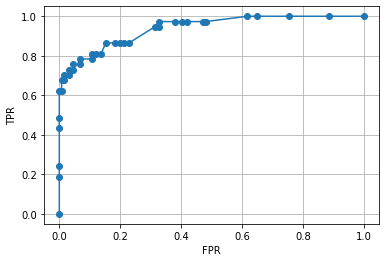

In [ ]:
#Bayesian Optimization
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

# BaysianOptimizationで最適化する関数を定義する
def get_model_predictions(X_test, model):
    yhat_test = model.predict(X_test)
    return yhat_test

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_predict

# BaysianOptimizationで最適化する関数を定義する
def xgb_regressor(max_depth, min_child_weight, gamma, subsample, colsample_bytree,reg_alpha, n_estimators, reg_lambda,learning_rate):

    params = {'max_depth':int(max_depth),
                'min_child_weight':int(min_child_weight),
                'gamma':gamma,
                'subsample':subsample,
                'colsample_bytree':colsample_bytree,
                'reg_alpha':reg_alpha,
                'n_estimators':int(n_estimators),
                'reg_lambda':reg_lambda,
                'learning_rate':learning_rate
                }
    model = xgb.XGBRegressor(**params,
                            early_stopping_rounds=50,
                            eval_set=[(X_test, Y_test)],
                            eval_metric='rmse',
                            silent=False,
                            n_jobs=-1
                            )

    Y_pred_cv = cross_val_predict(model,X_train,Y_train,cv=5, n_jobs=-1)
    rmse_cv = np.sqrt(mean_squared_error(Y_train, Y_pred_cv))

    return -rmse_cv

#ベイズ最適化で探索するパラメータ空間を定義する
xgb_bo = BayesianOptimization(xgb_regressor,
                            {'max_depth':(3,8),
                            'min_child_weight':(1,5),
                            'gamma':(0,0.5),
                            'subsample':(0.6,1),
                            'colsample_bytree':(0.6,1),
                            'reg_alpha':(1e-5,100),
                            'n_estimators':(1000,2000),
                            'reg_lambda':(1e-5,1),
                            'learning_rate':(0.1,0.3)
                            })

#ベイズ最適化を実行（scoreが最大となるようにパラメータを探索していく）
#init_point：初期に探索する点数
#acq:獲得関数。EIは(expected improvement)
xgb_bo.maximize(init_points=5, n_iter=200, acq='ei')

#最もスコアのよかったパラメータの値を取得する。
optimized_params = xgb_bo.max['params']

#整数のパラメータは変換
optimized_params['max_depth'] = int(optimized_params['max_depth'])
optimized_params['min_child_weight'] = int(optimized_params['min_child_weight'])
optimized_params['n_estimators'] = int(optimized_params['n_estimators'])

#調整したパラメータで精度検証する
opt_model = xgb.XGBRegressor()
opt_model.set_params(**optimized_params)
opt_model.fit(X_train, Y_train)
#y_pred_train = opt_model.predict(X_train)
#y_pred_test = opt_model.predict(X_test)
bestmodel = opt_model
print(bestmodel)

"""
# 学習モデルの評価（RMSEを計算）
print('RMSE(train data):',round(np.sqrt(mean_squared_error(Y_train, Y_pred_train)),3))
print('RMSE(test data):',round(np.sqrt(mean_squared_error(Y_test, Y_pred_test)),3))
#output
#RMSE(train data): 0.426
#RMSE(test data): 2.266
#CPU times: user 32.1 s, sys: 4.64 s, total: 36.7 s
#Wall time: 11min 42s

"""
#ここから学習モデルの評価

# 検証用データが各クラスに分類される確率を計算する
Y_pred_proba = bestmodel.predict(X_test)
# しきい値 0.5 で 0, 1 に丸める
Y_pred = np.where(Y_pred_proba > 0.5, 1, 0)
# 精度 (Accuracy) を検証する
acc = accuracy_score(Y_test, Y_pred)
print('Accuracy:', acc)

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print(tp, fn, fp, tn)

def specificity_score(label, pred):
    tn, fp, fn, tp = confusion_matrix(label, pred).flatten()
    return tn / (tn + fp)

print('confusion matrix = \n', confusion_matrix(Y_test, Y_pred))
print(f'Accuracy : {accuracy_score(Y_test, Y_pred)}')
print(f'Precision (true positive rate) : {precision_score(Y_test, Y_pred)}')
print(f'Recall (sensitivity): {recall_score(Y_test, Y_pred)}')
print(f'Specificity : {specificity_score(Y_test, Y_pred)}')
print(f'F1 score : {f1_score(Y_test, Y_pred)}')


#ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)     
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
print(f'Area_under_ROC : {roc_auc_score(Y_test, Y_pred_proba)}')
#plt.savefig('plots/roc_curve.png')